<div style="text-align: center;">
    <div class="Headline" style="display: inline-block; border: 2px solid #4CAF50; border-radius: 15px; background-color: #f9f9f9; padding: 20px; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
        <h3 style="margin: 0; text-align: center; color: #333;">
            <span id="title_page_challenge" style="font-size: 24px; font-weight: bold;">AI for Meter Reading</span>
            <br>
            <small style="font-size: 16px; color: #555;">par Yann Rousseau</small>
        </h3>
    </div>
</div>


# 1. Découverte du dataset.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage, Resize
from torchvision import transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

In [9]:
# path = './datas/'
# filepath = os.path.join(path, 'XTRAIN')
# with ZipFile(os.path.join(path, 'x_train.zip'), 'r') as zipfile:
#     zipfile.extractall(filepath)
#     print("Files extracted and folder {} created.".format(filepath))

In [10]:
# liste_images = os.listdir(filepath)
# fig = plt.figure(figsize=(15,6))


# for i, path_im in enumerate(liste_images[:10]):
#     im = plt.imread(os.path.join(filepath, path_im))
#     fig.add_subplot(2,5,i+1) ; plt.imshow(im)

# plt.tight_layout()
# plt.show()

On remarque que les images ne font pas toutes la même taille, que les numéros sont plus ou moins visibles. Comme ce sont les numéros qui nous intéressent, on peut remarquer une constance : un fond noir ou rouge, sur lequel sont affichés des numéros blancs.  Le reste de l'image n'est pas intéressant pour nous. On peut déja réfléchir à un nettoyage des images pour ne garder que cette partie qui nous intéresse. 

- En noir et blanc, c'est la valeur d'eau consommé en $m^3$
- En rouge et blanc, c'est la valeur d'eau consommé en litres.

Ce qui nous intéresse dans ce challenge, c'est d'obtenir la valeur des trois derniers numéros de la consommation en $m^3$.

In [11]:
y_train_csv = pd.read_csv('datasets/stockage/y_train.csv')
y_train_csv

,ID,index
0,0127d0,1416
1,012e2f,2556
2,01a650,250
3,0249c2,129
4,027912,1025
...,...,...
788,fe359d,216
789,fe5bf4,289
790,ff7912,624
791,ff9175,472


In [12]:
class WaterMeterDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Chemin vers le fichier CSV.
            img_dir (str): Répertoire contenant les images.
            transform (callable, optional): Transformations à appliquer aux images.
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

In [13]:
# transform = transforms.Compose([
#     transforms.Resize((400, 400)),  # Redimensionner les images
#     transforms.ToTensor()
# ])

# train_dataset = WaterMeterDataset(csv_file='datasets/stockage/y_train.csv', img_dir='D:/my_git/AIforMeterReading/datasets/dataset/train', transform=transform)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# fig = plt.figure(figsize=(20,10))
# imgs, labels = next(iter(train_dataloader))
# for i in range(6):
#     fig.add_subplot(2,3,i+1) ; plt.imshow(ToPILImage()(imgs[i])), plt.title(labels[i].item()) ,plt.axis('off')

# plt.show()

On constate certaines erreurs entre le label fourni et la réalité de l'image, par exemple pour l'image ```19d49d.jpg```, qui affiche **1770** $m^3$ et a pour label **889** (sa valeur en litres).

# 2. Repartition du dataset fourni

Il faut répartir les images dans trois dossiers ```/train/```, ```/val/```, ```/test/``` qui vont nous servir tout au long de l'apprentissage.

In [14]:
# import os
# import shutil
# import random

# source_dir = "datasets/x_train"

# # Dossiers de destination
# train_dir = "dataset/train"
# val_dir = "dataset/val"
# test_dir = "dataset/test"

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)


# train_ratio = 0.75  # 75% pour l'entraînement
# val_ratio = 0.15    # 15% pour la validation
# test_ratio = 0.1   # 10% pour le test


# # Liste des fichiers dans le dossier source
# files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# # Mélanger les fichiers aléatoirement
# random.shuffle(files)

# # Calcul des tailles des ensembles
# total_files = len(files)
# train_size = int(total_files * train_ratio)
# val_size = int(total_files * val_ratio)

# # Répartir les fichiers dans les ensembles
# train_files = files[:train_size]
# val_files = files[train_size:train_size + val_size]
# test_files = files[train_size + val_size:]

# # Fonction pour déplacer les fichiers
# def move_files(file_list, destination_dir):
#     for file in file_list:
#         shutil.move(os.path.join(source_dir, file), os.path.join(destination_dir, file))

# # Déplacer les fichiers
# move_files(train_files, train_dir)
# move_files(val_files, val_dir)
# move_files(test_files, test_dir)

# print(f"[INFO] Répartition terminée :")
# print(f" - Train : {len(train_files)} images")
# print(f" - Val   : {len(val_files)} images")
# print(f" - Test  : {len(test_files)} images")


# 3. Segmentation

On sent que pour arriver à nos fins, il serait idéal d'avoir une pipeline qui localise l'affichage du compteur (détection d'objets = cadran), qui l'isole, sur lequel on va ensuite appliquer des techniques d'OCR afin d'obtenir les numéros et ainsi estimer la consommation d'eau.

La première étape est donc de la **détection**. Pour se faire, un modèle très performant et reconnu est **YOLO** (version actuelle : 11). Maintenant, YOLO est entrainé pour reconnaitre tout un tas d'objets, mais pas vraiment de reconnaitre les cadrans de compteurs. Il faut alors le **finetune** pour avoir des résultats plus convaincants. 

## 3.1 Label des Bouncing Boxes d'entrainement.

--> cf le code ```annotation_manuelle.py```. 

## 3.2 Finetuning de YOLOV11

Cette partie a tourné sur *Google Colab* pour profiter du GPU. 

In [15]:
# # %pip install ultralytics
# import ultralytics
# ultralytics.checks()

In [16]:
# !yolo task=detect mode=train model=yolo11n.pt data=drive/MyDrive/AIforMeterReading/data.yaml epochs=20 imgsz=640

In [17]:
# !yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=drive/MyDrive/AIforMeterReading/data.yaml imgsz=640

## 3.3 Detection et segmentation large (pour une seule image)

On peut prédire des boites englobantes en quelques lignes. Elles sont enregistrées dans un dossier.

In [18]:
# !yolo predict model=bbox_yolov11_200train.pt source='datasets/dataset/val'

Ce qui nous intéresse, c'est de segmenter pour ne garder que les parties intéressantes. Pour ça, on convertit les boites englobantes en des masques binaires, qu'on applique sur les images. Il ne nous restera plus que les cadrans pour la suite.


image 1/1 d:\my_git\AIforMeterReading\datasets\dataset\train\0af124.jpg: 384x640 1 Cadran m3, 75.0ms
Speed: 1.5ms preprocess, 75.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


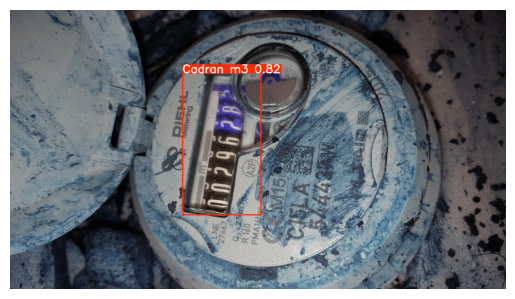

In [19]:
from ultralytics import YOLO

# Test avec un modèle pré-entraîné de YOLO
model = YOLO("bbox_yolov11_200train.pt")
image_name = 'datasets/dataset/train/0af124.jpg'
results = model.predict(source=image_name)  # Remplacez par une image existante
plt.imshow(results[0].plot()), plt.axis('off')
plt.show()

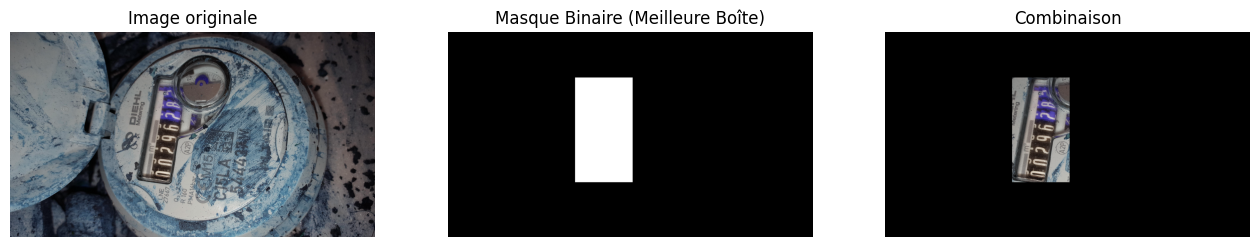

Boîte sélectionnée : 1849, 674, 2687, 2193


In [20]:
original_image = cv2.imread(image_name)
height, width = original_image.shape[:2]  # Dimensions de l'image

boxes = results[0].boxes

if len(boxes) > 0:
    xyxy = boxes.xyxy.cpu().numpy()  # Coordonnées (x_min, y_min, x_max, y_max)
    confidences = boxes.conf.cpu().numpy()  # Scores de confiance

    # Trouver la boîte avec le score de confiance le plus élevé
    max_idx = np.argmax(confidences)
    best_box = xyxy[max_idx]  # Coordonnées de la meilleure boîte
    x_min, y_min, x_max, y_max = map(int, best_box)

    # Créer un masque binaire
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[y_min:y_max, x_min:x_max] = 255  # Région détectée en blanc

    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)

    # Visualiser le masque binaire
    fig = plt.figure(figsize=(16, 8))
    fig.add_subplot(1,3,1), plt.title("Image originale")
    plt.imshow(original_image)
    plt.axis("off")
    fig.add_subplot(1,3,2), plt.title("Masque Binaire (Meilleure Boîte)")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    fig.add_subplot(1,3,3), plt.title("Combinaison")
    plt.imshow(masked_image)
    plt.axis("off")
    plt.show()

    print(f"Boîte sélectionnée : {x_min}, {y_min}, {x_max}, {y_max}")
    
else:
    print("[INFO] Aucune boîte détectée.")

## 3.4 Detection et segmentation large (sur tout le dataset)

Deux possibilités s'offrent à nous : 
- intégrer la segmentation dans notre pipeline d'apprentissage (Transforms ou \__getitem__)
- Effectuer la segmentation en amont pour créer un nouveau dataset d'entrainement. 

L'idéal est la première option, nous permettant d'éviter de devoir relancer cette partie manuellement à chaque nouveau changement de database. Cependant, on ne peut pas regarder en amont si la segmentation s'est bien passé. Il faut alors avoir confiance en notre modèle, et prévoir les cas où on ne trouvera pas de bounding boxes.

Ceci dit, cela ne nous coute pas grand chose d'appliquer notre modèle sur l'entièreté de la database, et parcourir les résultats pour observer la qualité de la segmentation.

In [21]:
import shutil

In [22]:
def segment_from_bbox(image, directory, model, i, verbose=True):

    img_path = os.path.join(directory, image)
    results = model.predict(source=img_path, verbose=False)

    original_image = cv2.imread(img_path)
    height, width = original_image.shape[:2]  # Dimensions de l'image

    boxes = results[0].boxes

    if len(boxes) > 0:
        xyxy = boxes.xyxy.cpu().numpy()  # Coordonnées (x_min, y_min, x_max, y_max)
        confidences = boxes.conf.cpu().numpy()  # Scores de confiance

        # Trouver la boîte avec le score de confiance le plus élevé
        max_idx = np.argmax(confidences)
        best_box = xyxy[max_idx]  # Coordonnées de la meilleure boîte
        x_min, y_min, x_max, y_max = map(int, best_box)

        # Extraire la région d'intérêt (ROI)
        cropped_image = original_image[y_min:y_max, x_min:x_max]
        cv2.imwrite(filename=image, img=cropped_image)
        return 0
        
    else:
        if verbose:
            print(f"[INFO] Aucune boîte détectée pour {image}.")
        cv2.imwrite(filename=image, img=original_image)
        return 1

In [23]:
# direct_in = 'datasets/dataset/val'
# direct_out = 'val_segment'
# no_segmentation = 0

# if not os.path.exists(direct_out):
#     os.makedirs(direct_out)

# for k, im in enumerate(os.listdir(direct_in)):
#     no_segmentation += segment_from_bbox(im, direct_in, model, k)
#     shutil.move(im, os.path.join(direct_out, im))

Après le test de notre programme et notre modèle de segmentation sur 117 images (dossier ```/val/```), on obtient :
- 4 images sur 117 (3%) n'ont eu aucun cadran détecté.
- toutes les autres images ont eu leur cadran de détecté.
 
Conclusion : notre modèle est assez efficace pour segmenter le cadran.

On applique alors notre programme sur la base de données ```/train/``` et ```/test/``` .

In [24]:
# from tqdm import tqdm

# direct_in = 'datasets/dataset/test'
# direct_out = 'datasets/dataset/test_segment'
# no_segmentation = 0

# if not os.path.exists(direct_out):
#     os.makedirs(direct_out)

# for k, im in enumerate(tqdm(os.listdir(direct_in))):
#     no_segmentation += segment_from_bbox(im, direct_in, model, k, verbose=False)
#     shutil.move(im, os.path.join(direct_out, im))

# print("NOMBRE D'IMAGES NON SEGMENTÉS : {:d} / {:d}".format(no_segmentation, len(os.listdir(direct_out))))

In [25]:
# direct_in = 'datasets/dataset/train'
# direct_out = 'datasets/dataset/train_segment'
# no_segmentation = 0

# if not os.path.exists(direct_out):
#     os.makedirs(direct_out)

# for k, im in enumerate(tqdm(os.listdir(direct_in))):
#     no_segmentation += segment_from_bbox(im, direct_in, model, k)
#     shutil.move(im, os.path.join(direct_out, im))

# print("NOMBRE D'IMAGES NON SEGMENTÉS : {:d} / {:d}".format(no_segmentation, len(os.listdir(direct_out))))

Sur 594 images, 37 ne sont pas segmentés du tout (6%). C'est une piste d'amélioration possible pour la suite. Cependant, on va passer à la prochaine étape : **OCR**.

# 4. Détection des digits.

On a testé des logiciels d'OCR reconnus comme Tesseract, mais ce n'était pas concluant, en tout cas l'input n'était pas celui attendu pour être parfaitement efficace.

En règle général sont conçus des modèles pour reconnaitre des chiffres entre 0 et 9. En effet, on conçoit mal de donner en inputs les 8 chiffres et d'obtenir en output une valeur comprise entre 0 et 999. 

Il faut donc concevoir un code qui nous permettrait de découper les cases de chaque chiffre, et de lire le chiffre présent dans cette case. ![alt text](<notebook_utils/0 0 7 7 6.png>)

Une idée serait encore une fois d'entrainer un modèle YOLO personnalisé qui identifie les boites contenant les chiffres. N'y a-t-il pas une manière sans faire appel aux réseaux neuronaux ?

### 4.1 Open CV

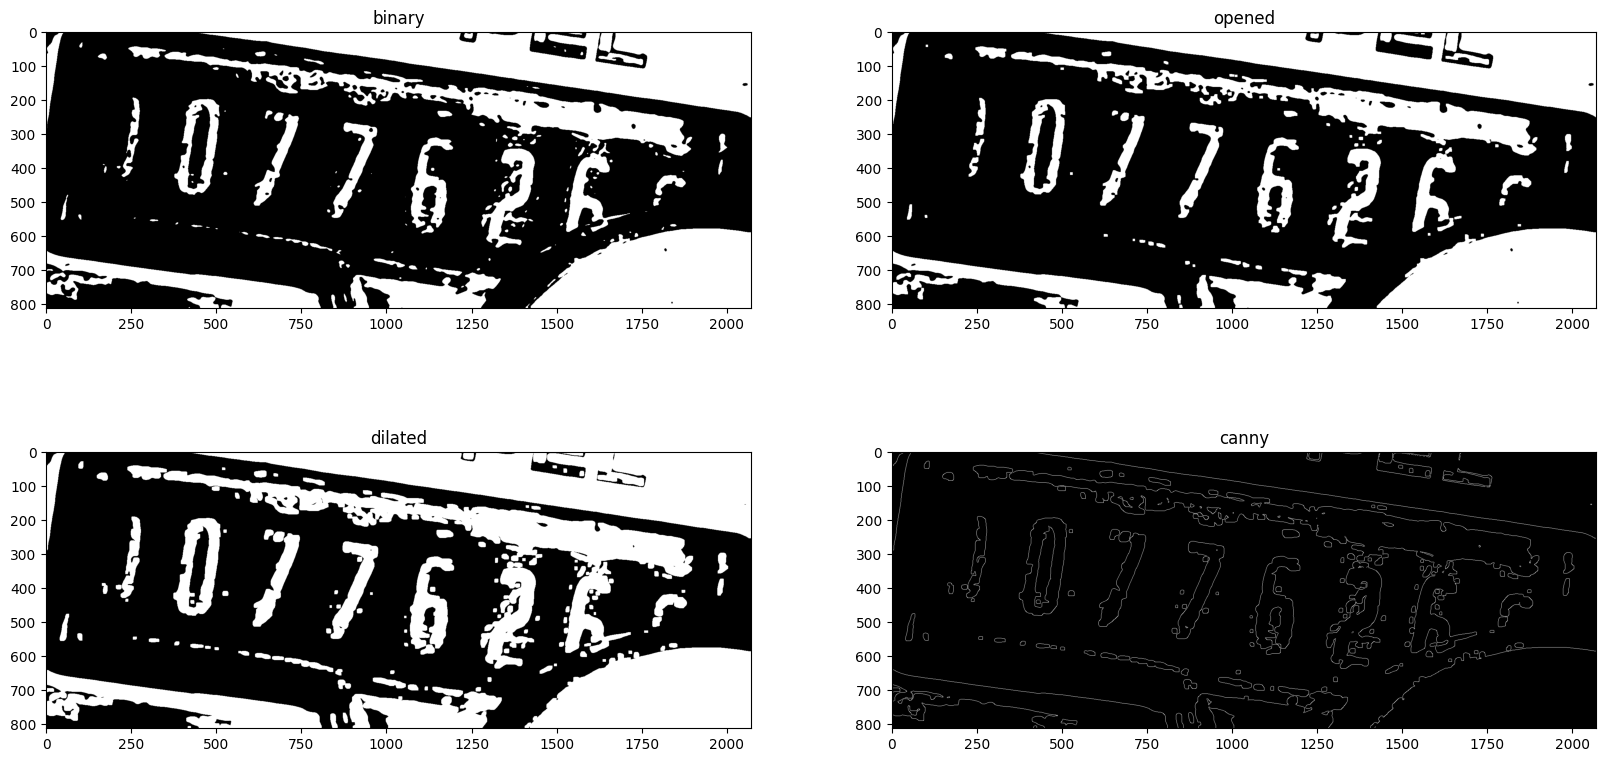

In [26]:
img_path = 'datasets/dataset/train_segment/1a3c33.jpg'
image = cv2.imread(img_path)

im3 = image.copy()
im3 = cv2.rotate(im3, cv2.ROTATE_90_CLOCKWISE)
gray = cv2.cvtColor(im3,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(11,11),64)
ret,thresh1 = cv2.threshold(blur,140,255,cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Carré de 3x3
dilated = cv2.dilate(thresh1, kernel, iterations=3)

opened = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel, iterations=3)

canny = cv2.Canny(dilated, 0, 255)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,2,1), plt.imshow(cv2.cvtColor(thresh1, cv2.COLOR_BGR2RGB)), plt.title('binary')
fig.add_subplot(2,2,2), plt.imshow(cv2.cvtColor(opened, cv2.COLOR_BGR2RGB)), plt.title('opened')
fig.add_subplot(2,2,3), plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB)), plt.title('dilated')
fig.add_subplot(2,2,4), plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB)), plt.title('canny')
plt.show()

### 4.2 YOLOV11

On a annoté une centaine d'images avec [Label Studio](https://labelstud.io/). On a ensuite **finetune** un modèle YOLO(V11). On obtient alors un modèle qui identifie les boxing box contenant des digits. Il suffira alors d'extraire les imagettes (dans le bon ordre), d'appliquer un CNN entrainé sur MNIST par exemple, et on obtiendra une suite de chiffres que l'on transformera en nombre.

<figure>
    <center>
    <img src="notebook_utils/lblstudio.png" alt="Image" width="1000">
    <figcaption>Annotation sur <em>Label Studio</em></figcaption>
</figure>


image 1/1 d:\my_git\AIforMeterReading\datasets\dataset\train_segment\0af124.jpg: 640x384 7 digits, 87.6ms
Speed: 5.8ms preprocess, 87.6ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 384)


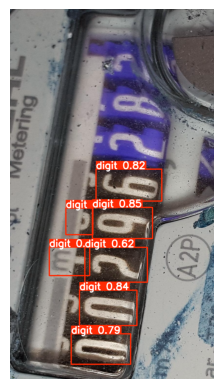

In [27]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np 

model = YOLO("digits_yolov11.pt")
image_name = 'datasets/dataset/train_segment/0af124.jpg'
results = model.predict(source=image_name)
plt.imshow(results[0].plot()), plt.axis('off')
plt.show()

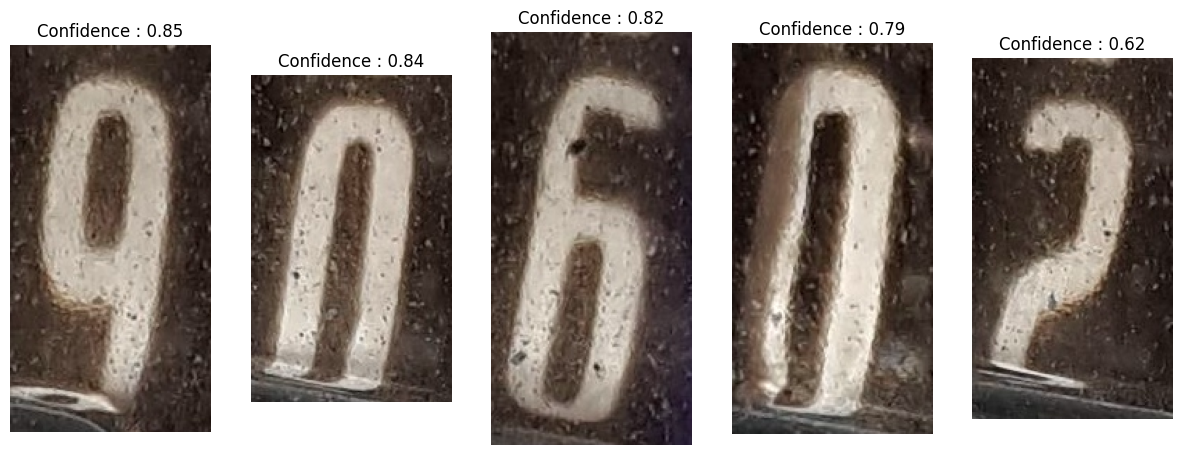

In [28]:
boxes = results[0].boxes
imagettes = []
confidences = []

if len(boxes) > 0:
    original_image = results[0].orig_img
    for box in boxes:
        xyxy = box.xyxy.cpu().numpy()[0]  # Coordonnées (x_min, y_min, x_max, y_max)
        confidence = box.conf.cpu().numpy()  # Scores de confiance
        if confidence > 0.55:
            x_min, y_min, x_max, y_max = map(int, xyxy)
            imagettes.append(original_image[y_min:y_max, x_min:x_max])
            confidences.append(confidence)

fig = plt.figure(figsize=(15,6))
for k in range(len(imagettes)):
    fig.add_subplot(1,len(imagettes), k+1), plt.imshow(np.rot90(imagettes[k], axes=(1,0))), plt.title("Confidence : {:.2f}".format(confidences[k].item())), plt.axis('off')
plt.show()